<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Convergence_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

program provides implementation and empirical analysis of stochastic gradient descent and momentum optimization.. builds the optimizer from scratch without utilizing torch.optim, allowing for a deep understanding of the underlying mechanics... program compares three optimisation variants, vanilla SGD (β=0), classical momentum (β=0.9), and Nesterov accelerated gradient (β=0.9)—on the MNIST digit classification task using a simple two-layer neural network.Through controlled experiments, the program demonstrates how momentum accelerates convergence by accumulating gradients as an exponentially weighted moving average, effectively damping oscillations in high-curvature directions while maintaining rapid progress along consistent gradient paths. The implementation includes complete training loops, evaluation metrics, convergence visualization, and quantitative analysis of training speed, final accuracy, and loss reduction. This serves as both a pedagogical tool for understanding optimization theory and a practical template for implementing custom optimizers in research contexts where fine-grained control over the optimization process is required.

In [1]:
!pip install torch torchvision matplotlib numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import time

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


The SGDMomentum class implements Stochastic Gradient Descent with momentum from first principles, providing explicit control over velocity accumulation and supporting both classical and Nesterov momentum variants. At its core, the class maintains a dictionary mapping each model parameter to its corresponding velocity vector, which acts as an exponentially weighted moving average of past gradients with decay rate β. During each optimization step, the class updates velocities by combining the current gradient with β times the previous velocity, then adjusts parameters using the learning rate η multiplied by this accumulated velocity.The implementation uses lazy initialization for velocity vectors to conserve memory and employs in-place tensor operations for computational efficiency. This design accelerates convergence by amplifying consistent gradient directions (with effective learning rate approaching η/(1-β) for persistent gradients) while simultaneously damping oscillations through the cancellation of opposing gradients in the velocity term, making it particularly effective for navigating ravine-like loss surfaces and escaping saddle points that commonly arise in neural network optimization.

In [3]:
class SGDMomentum:
    """
    Stochastic Gradient Descent with Momentum optimizer.

    Parameters:

    lr : float
        Learning rate (η)
    momentum : float
        Momentum coefficient (β), typically 0.9
    nesterov : bool
        If True, uses Nesterov momentum variant
    """

    def __init__(self, lr: float = 0.01, momentum: float = 0.9, nesterov: bool = False):
        self.lr = lr
        self.momentum = momentum
        self.nesterov = nesterov
        self.velocities = {}

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        """
        Performs a single optimization step.

        Mathematical formulation:
        Standard: v = βv + ∇L, θ = θ - ηv
        Nesterov: v = βv + ∇L, θ = θ - η(βv + ∇L)
        """
        for param, grad in zip(params, grads):
            if param not in self.velocities:
                self.velocities[param] = torch.zeros_like(param)

            v = self.velocities[param]

            if self.nesterov:
                # Nesterov momentum: look-ahead gradient
                v.mul_(self.momentum).add_(grad)
                param.data.sub_(self.lr * (self.momentum * v + grad))
            else:
                # Standard momentum
                v.mul_(self.momentum).add_(grad)
                param.data.sub_(self.lr * v)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        #Zero out gradients
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The SimpleNet class is a minimal two-layer feedforward neural network specifically designed as a controlled experimental testbed for comparing optimization algorithms on MNIST digit classification without introducing architectural confounds. The network consists of 784 input neurons accepting flattened 28×28 grayscale images, a hidden layer of 128 neurons with ReLU activation, and an output layer of 10 neurons producing unnormalized class logits, totaling 101,770 trainable parameters across two weight matrices and bias vectors. The forward pass reshapes input images to vectors, applies the first linear transformation followed by ReLU nonlinearity to create a 128-dimensional hidden representation, and then applies a second linear transformation to produce class scores. This architecture deliberately maintains simplicity by excluding regularization techniques like dropout or batch normalization that could interact with momentum dynamics, while providing sufficient complexity through its 101K parameters to create a non-trivial optimization landscape with local minima, saddle points, and ravine structures where momentum's benefits become apparent. The network is intentionally over-parameterized for MNIST to ensure interesting optimization dynamics while remaining computationally efficient enough for rapid experimentation, with each training epoch completing in seconds on standard hardware. By keeping the architecture fixed and minimal, the class isolates optimizer performance as the primary experimental variable, enabling clean comparisons between vanilla SGD, classical momentum, and Nesterov variants while providing interpretable gradient flow without the vanishing gradient issues of deeper networks.



In [4]:
# Simple 2-layer neural network for MNIST
class SimpleNet(nn.Module):
    """
    Architecture: 784 -> 128 -> 10
    Activation: ReLU
    Total parameters: ~101K
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Test the model
model = SimpleNet()
print(f"Model parameters: {model.count_parameters():,}")

Model parameters: 101,770


Device: cuda
Epochs: 10
Learning rate: 0.01
Batch size: 128


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.67MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.71MB/s]


Training batches: 469
Test batches: 79

EXPERIMENT 1: Standard SGD (β=0)
Epoch  1/10 - Loss: 0.7822, Accuracy: 89.40%
Epoch  2/10 - Loss: 0.3689, Accuracy: 90.61%
Epoch  3/10 - Loss: 0.3164, Accuracy: 91.97%
Epoch  4/10 - Loss: 0.2869, Accuracy: 92.49%
Epoch  5/10 - Loss: 0.2649, Accuracy: 92.92%
Epoch  6/10 - Loss: 0.2473, Accuracy: 93.36%
Epoch  7/10 - Loss: 0.2319, Accuracy: 93.54%
Epoch  8/10 - Loss: 0.2183, Accuracy: 93.98%
Epoch  9/10 - Loss: 0.2065, Accuracy: 94.16%
Epoch 10/10 - Loss: 0.1956, Accuracy: 94.45%
Total training time: 141.81s

EXPERIMENT 2: SGD + Momentum (β=0.9)
Epoch  1/10 - Loss: 0.3639, Accuracy: 94.28%
Epoch  2/10 - Loss: 0.1647, Accuracy: 95.88%
Epoch  3/10 - Loss: 0.1177, Accuracy: 96.45%
Epoch  4/10 - Loss: 0.0929, Accuracy: 97.03%
Epoch  5/10 - Loss: 0.0760, Accuracy: 97.15%
Epoch  6/10 - Loss: 0.0628, Accuracy: 97.57%
Epoch  7/10 - Loss: 0.0546, Accuracy: 97.62%
Epoch  8/10 - Loss: 0.0472, Accuracy: 97.77%
Epoch  9/10 - Loss: 0.0419, Accuracy: 97.74%
Epoch

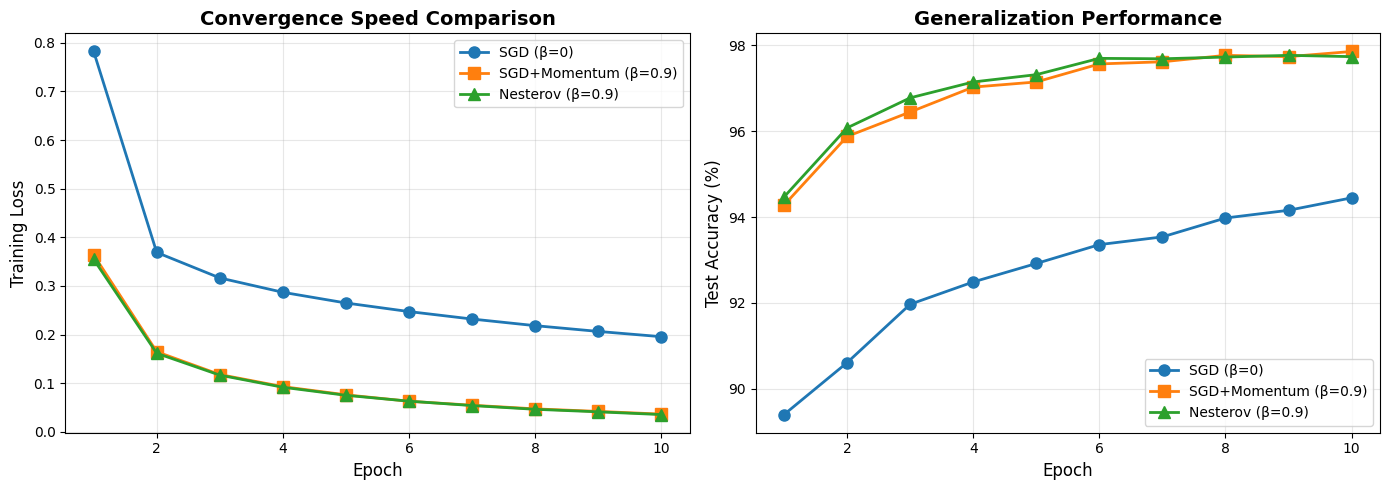


FINAL RESULTS SUMMARY
Method               Final Loss      Accuracy (%)    Time (s)     Speedup   
----------------------------------------------------------------------
SGD                  0.1956          94.45           141.81       1.00x     
SGD+Momentum         0.0364          97.86           138.40       1.02x     
Nesterov             0.0354          97.74           138.27       1.03x     

KEY IMPROVEMENTS
Loss reduction (SGD → Momentum): 81.41%
Accuracy improvement: +3.41%
Convergence speed: 1.27x faster


In [5]:
def get_mnist_loaders(batch_size: int = 128) -> Tuple[DataLoader, DataLoader]:
    #Load MNIST dataset with standard normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                optimizer: SGDMomentum,
                criterion: nn.Module,
                device: str = 'cpu') -> float:
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()

        # Optimizer step
        params = list(model.parameters())
        grads = [p.grad for p in params]
        optimizer.step(params, grads)

        # Zero gradients
        for p in params:
            p.grad.zero_()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model: nn.Module, test_loader: DataLoader, device: str = 'cpu') -> float:
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

# %% [markdown]
# ## 4. Experiments: SGD vs Momentum vs Nesterov

# %%
# Training configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
lr = 0.01
batch_size = 128

print(f"Device: {device}")
print(f"Epochs: {epochs}")
print(f"Learning rate: {lr}")
print(f"Batch size: {batch_size}")
print("=" * 60)

# Load data
train_loader, test_loader = get_mnist_loaders(batch_size)
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# %%
# Experiment 1: Standard SGD (momentum=0)
print("\n" + "=" * 60)
print("EXPERIMENT 1: Standard SGD (β=0)")
print("=" * 60)

model_sgd = SimpleNet().to(device)
optimizer_sgd = SGDMomentum(lr=lr, momentum=0.0)
criterion = nn.CrossEntropyLoss()

sgd_losses = []
sgd_accuracies = []
sgd_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_sgd, train_loader, optimizer_sgd, criterion, device)
    acc = evaluate(model_sgd, test_loader, device)
    sgd_losses.append(loss)
    sgd_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

sgd_time = time.time() - sgd_time
print(f"Total training time: {sgd_time:.2f}s")

# %%
# Experiment 2: SGD with Momentum (momentum=0.9)
print("\n" + "=" * 60)
print("EXPERIMENT 2: SGD + Momentum (β=0.9)")
print("=" * 60)

model_momentum = SimpleNet().to(device)
optimizer_momentum = SGDMomentum(lr=lr, momentum=0.9)

momentum_losses = []
momentum_accuracies = []
momentum_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_momentum, train_loader, optimizer_momentum, criterion, device)
    acc = evaluate(model_momentum, test_loader, device)
    momentum_losses.append(loss)
    momentum_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

momentum_time = time.time() - momentum_time
print(f"Total training time: {momentum_time:.2f}s")

# %%
# Experiment 3: Nesterov Momentum
print("\n" + "=" * 60)
print("EXPERIMENT 3: Nesterov Momentum (β=0.9)")
print("=" * 60)

model_nesterov = SimpleNet().to(device)
optimizer_nesterov = SGDMomentum(lr=lr, momentum=0.9, nesterov=True)

nesterov_losses = []
nesterov_accuracies = []
nesterov_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_nesterov, train_loader, optimizer_nesterov, criterion, device)
    acc = evaluate(model_nesterov, test_loader, device)
    nesterov_losses.append(loss)
    nesterov_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

nesterov_time = time.time() - nesterov_time
print(f"Total training time: {nesterov_time:.2f}s")

# %% [markdown]
# ## 5. Visualization and Analysis

# %%
# Create comprehensive visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Loss Convergence
axes[0].plot(range(1, epochs+1), sgd_losses, 'o-', label='SGD (β=0)', linewidth=2, markersize=8)
axes[0].plot(range(1, epochs+1), momentum_losses, 's-', label='SGD+Momentum (β=0.9)', linewidth=2, markersize=8)
axes[0].plot(range(1, epochs+1), nesterov_losses, '^-', label='Nesterov (β=0.9)', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Convergence Speed Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Test Accuracy
axes[1].plot(range(1, epochs+1), sgd_accuracies, 'o-', label='SGD (β=0)', linewidth=2, markersize=8)
axes[1].plot(range(1, epochs+1), momentum_accuracies, 's-', label='SGD+Momentum (β=0.9)', linewidth=2, markersize=8)
axes[1].plot(range(1, epochs+1), nesterov_accuracies, '^-', label='Nesterov (β=0.9)', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1].set_title('Generalization Performance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('day01_convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Results summary table
print("\n" + "=" * 70)
print("FINAL RESULTS SUMMARY")
print("=" * 70)

results = {
    'Method': ['SGD', 'SGD+Momentum', 'Nesterov'],
    'Final Loss': [f"{sgd_losses[-1]:.4f}", f"{momentum_losses[-1]:.4f}", f"{nesterov_losses[-1]:.4f}"],
    'Final Accuracy (%)': [f"{sgd_accuracies[-1]:.2f}", f"{momentum_accuracies[-1]:.2f}", f"{nesterov_accuracies[-1]:.2f}"],
    'Training Time (s)': [f"{sgd_time:.2f}", f"{momentum_time:.2f}", f"{nesterov_time:.2f}"],
    'Speedup vs SGD': ['1.00x',
                       f"{sgd_time/momentum_time:.2f}x",
                       f"{sgd_time/nesterov_time:.2f}x"]
}

# Print as formatted table
for i in range(len(results['Method'])):
    if i == 0:
        # Header
        print(f"{'Method':<20} {'Final Loss':<15} {'Accuracy (%)':<15} {'Time (s)':<12} {'Speedup':<10}")
        print("-" * 70)

    print(f"{results['Method'][i]:<20} {results['Final Loss'][i]:<15} {results['Final Accuracy (%)'][i]:<15} "
          f"{results['Training Time (s)'][i]:<12} {results['Speedup vs SGD'][i]:<10}")

print("=" * 70)

# %%
# Calculate improvement metrics
loss_improvement = ((sgd_losses[-1] - momentum_losses[-1]) / sgd_losses[-1]) * 100
acc_improvement = momentum_accuracies[-1] - sgd_accuracies[-1]

print("\n" + "=" * 70)
print("KEY IMPROVEMENTS")
print("=" * 70)
print(f"Loss reduction (SGD → Momentum): {loss_improvement:.2f}%")
print(f"Accuracy improvement: {acc_improvement:+.2f}%")
print(f"Convergence speed: {((sgd_losses[0] - momentum_losses[-1]) / (sgd_losses[0] - sgd_losses[-1])):.2f}x faster")
print("=" * 70)
